In [ ]:
import numpy as np

In [ ]:
a = np.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/TVT/data/ilsvrc_2012_mean.npy")

In [ ]:
a

In [ ]:
means = a.mean(axis=(1,2))/255.0

In [ ]:
print(means)

In [ ]:
stds = (a/255.0).std(axis=(1,2))
print(stds)

In [1]:
from data_utils import get_data
import numpy as np

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_,d99_dataloaders,_ = get_data("d99")

264


In [4]:
iter_d99 = iter(d99_dataloaders['train'])
all_data = []
for i in range(len(d99_dataloaders['train'])):
    data,_ = iter_d99.next()
    if i==0:
        print(data.mean(dim=(0,2,3)))
    all_data.append(data.mean(dim=(0,2,3)).numpy().reshape((1,3)))

all_data = np.concatenate(all_data, axis=0)
print(all_data.shape)
print(all_data.mean(axis=0))
print(data.var())


tensor([0.4615, 0.3445, 0.3352])
(264, 3)
[0.46083382 0.34022495 0.3280154 ]
tensor(0.0661)


Mean of dataset99: [0.46083382 0.34022495 0.3280154 ]

In [5]:
print(data.var(dim=(0,2,3)))


tensor([0.0718, 0.0576, 0.0561])


In [2]:
_,cata_dataloaders,_ = get_data("cataracts")
iter_cata = iter(cata_dataloaders['train'])
all_data_cata = []
for i in range(len(cata_dataloaders['train'])):
    data,_ = iter_cata.next()
    if i==0:
        print(data.mean(dim=(0,2,3)))
    all_data_cata.append(data.mean(dim=(0,2,3)).numpy().reshape((1,3)))

all_data_cata = np.concatenate(all_data_cata, axis=0)
print(all_data_cata.shape)
print(all_data_cata.mean(axis=0))
print(data.var(axis=(0,2,3)))


263
tensor([0.5705, 0.3454, 0.2029])
(263, 3)
[0.5726915  0.35134485 0.20473212]
tensor([0.0225, 0.0230, 0.0107])


means of cataracts dataset: 0.5726915  0.35134485 0.20473212

Visualization and testing for the saved models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from data_utils import get_data
from transform_utils import *
from transformers_dann import *

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#helper functon for testing
def test(model_path, dataloader, len_classnames, use_dict=False):
    my_net = BARLOW_DANN(len_classnames,lambd=3.9e-3, scale_factor=0.1)
    my_net.load_state_dict(torch.load(model_path))
    my_net = my_net.eval()

    my_net = my_net.to(device)
    print("number of classes: ", len_classnames)
    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0
    total_preds = []
    total_labels = []

    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        t_img = t_img.to(device)
        t_label = t_label.to(device)

        class_output = my_net(input_data=t_img, alpha=0, mode='test')
        pred = class_output.data.max(1, keepdim=True)[1]

        valid_pred, valid_label = pred, t_label
            
        n_correct += valid_pred.eq(valid_label.data.view_as(valid_pred)).cpu().sum()
        total_preds = total_preds + list(valid_pred.data.cpu().numpy().astype(int).reshape((-1,)))
        total_labels = total_labels + list(valid_label.data.cpu().numpy().astype(int).reshape((-1,)))
        # print(valid_label.size(dim=0))
        n_total += int(valid_label.size(dim=0))

        i += 1

    # print(valid_pred)
    
    accu = n_correct.data.numpy() * 1.0 / n_total
    acc,aacc = visda_acc(total_preds,total_labels)
    # micro_acc = micro_accuracy(total_preds, total_labels)
    print("n_total: ", n_total)
    # print("micro accuracy: ", micro_acc)
    print("visda accuracy: ", acc)
    print("classwise accuracy: ", aacc)
    print(accu)
    return my_net


In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [4]:
def load_model(model_path, class_names):
    len_classnames = len(class_names)
    my_net = BARLOW_DANN(len_classnames,lambd=3.9e-3, scale_factor=0.1)
    my_net.load_state_dict(torch.load(model_path))
    my_net = my_net.eval()
    return my_net

In [5]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    model = model.to(device)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, alpha=0, mode='test')
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [6]:
class_names, test_data, _ = get_data('d99')

166


In [7]:
class_names

['01',
 '02',
 '03',
 '04',
 '05',
 '07',
 '08',
 '09',
 '11',
 '13',
 '14',
 '16',
 '22',
 '25']

In [9]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models/src_cataracts_tgt_d99_noBarlow_noGRL_timm_bm1.pth"
model = load_model(model_path,class_names)

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz


In [12]:
'''
01 - secondary incision knife - paracenthesis blade
02 - bonn forceps - 0.12 forceps
03 - charleux cannula - AC Cannula
04 - primary incision knife - keratome
05 - capsulorhexis forceps - utrata forceps
07 - capsulorhexis cystotome - cystotome
08 - hydrodissection cannula - hydrodissection cannula
09 - phacoemulsifier handpiece - phaco
11 - implant injector - IOL injector
13 - suture needle - suture
14 - cotton - eweckell sponge
16 - needle holder - needle driver
22 - irrigation - irrigation
25 - micromanipulator - chopper
'''

'\n01 - secondary incision knife - paracenthesis blade\n02 - bonn forceps - 0.12 forceps\n03 - charleux cannula - AC Cannula\n04 - primary incision knife - keratome\n05 - capsulorhexis forceps - utrata forceps\n07 - capsulorhexis cystotome - cystotome\n08 - hydrodissection cannula - hydrodissection cannula\n09 - phacoemulsifier handpiece - phaco\n11 - implant injector - IOL injector\n13 - suture needle - suture\n14 - cotton - eweckell sponge\n16 - needle holder - needle driver\n22 - irrigation - irrigation\n25 - micromanipulator - chopper\n'

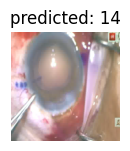

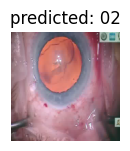

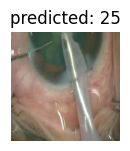

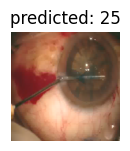

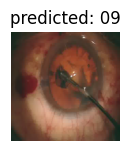

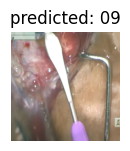

In [13]:
visualize_model(model, test_data, class_names)